In [ ]:
pip install yfinance pmdarima

# Grid Search ARIMA

[*********************100%***********************]  1 of 1 completed



================================== ANTM.JK ==================================



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  720
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -3726.567
Date:                Fri, 28 Nov 2025   AIC                           7459.135
Time:                        19:24:58   BIC                           7472.868
Sample:                             0   HQIC                          7464.437
                                - 720                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.9267      1.813     -0.511      0.609      -4.480       2.626
ma.L1          0.0609      0.032      1.916      0.055      -0.001       0.123
sigma2      1860.0464     60.671     30.658      0.0

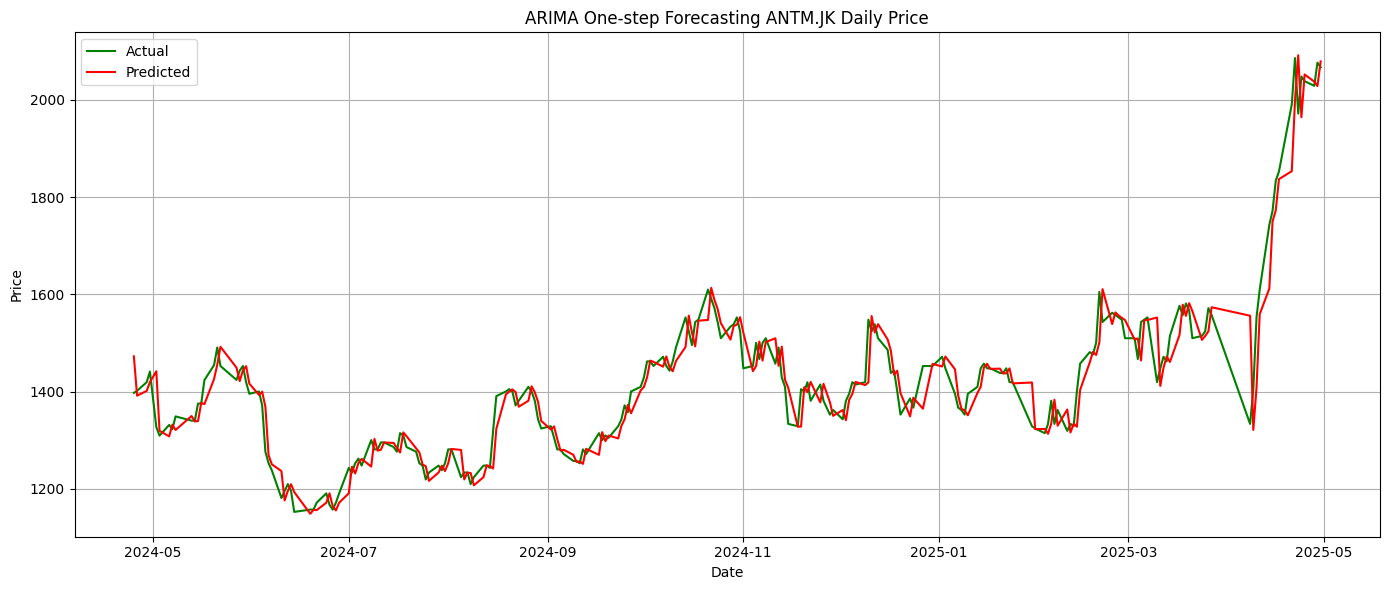

[*********************100%***********************]  1 of 1 completed



================================== BBNI.JK ==================================



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  720
Model:               SARIMAX(0, 1, 3)   Log Likelihood               -3931.314
Date:                Fri, 28 Nov 2025   AIC                           7872.629
Time:                        19:25:12   BIC                           7895.518
Sample:                             0   HQIC                          7881.466
                                - 720                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.5284      2.358      1.496      0.135      -1.093       8.150
ma.L1         -0.0492      0.031     -1.591      0.112      -0.110       0.011
ma.L2          0.0734      0.036      2.031      0.0

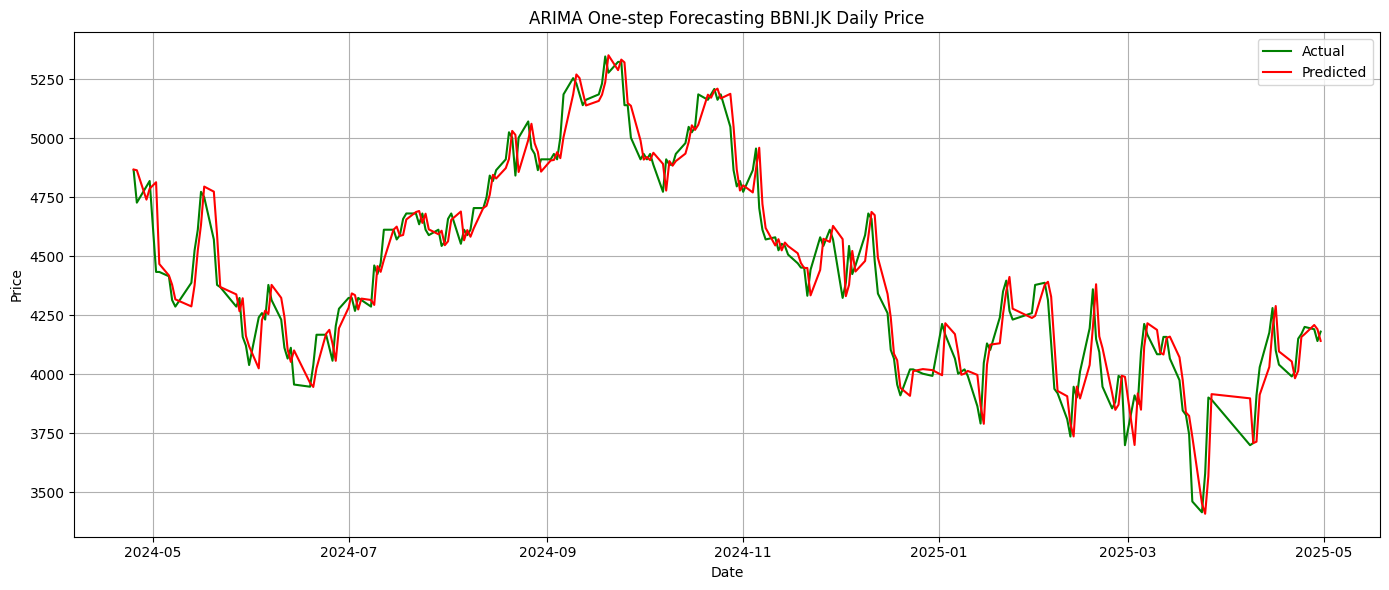

[*********************100%***********************]  1 of 1 completed



================================== BBRI.JK ==================================



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  720
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -3964.556
Date:                Fri, 28 Nov 2025   AIC                           7935.113
Time:                        19:25:34   BIC                           7948.846
Sample:                             0   HQIC                          7940.415
                                - 720                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.9213      2.249      1.299      0.194      -1.487       7.329
ar.L1         -0.1097      0.035     -3.145      0.002      -0.178      -0.041
sigma2      3608.4113    134.103     26.908      0.0

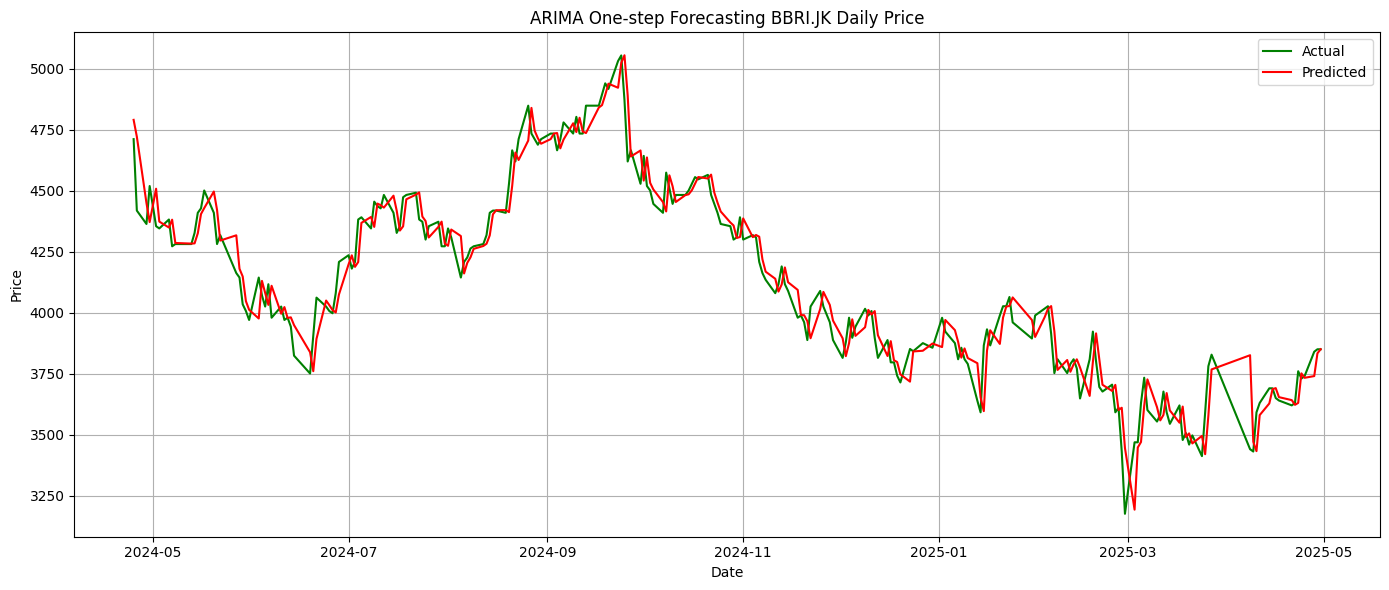

[*********************100%***********************]  1 of 1 completed



================================== BMRI.JK ==================================



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  720
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -3995.758
Date:                Fri, 28 Nov 2025   AIC                           7999.516
Time:                        19:25:44   BIC                           8017.828
Sample:                             0   HQIC                          8006.586
                                - 720                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.5557      1.981      2.805      0.005       1.674       9.438
ma.L1         -0.0997      0.029     -3.496      0.000      -0.156      -0.044
ma.L2         -0.0601      0.033     -1.834      0.0

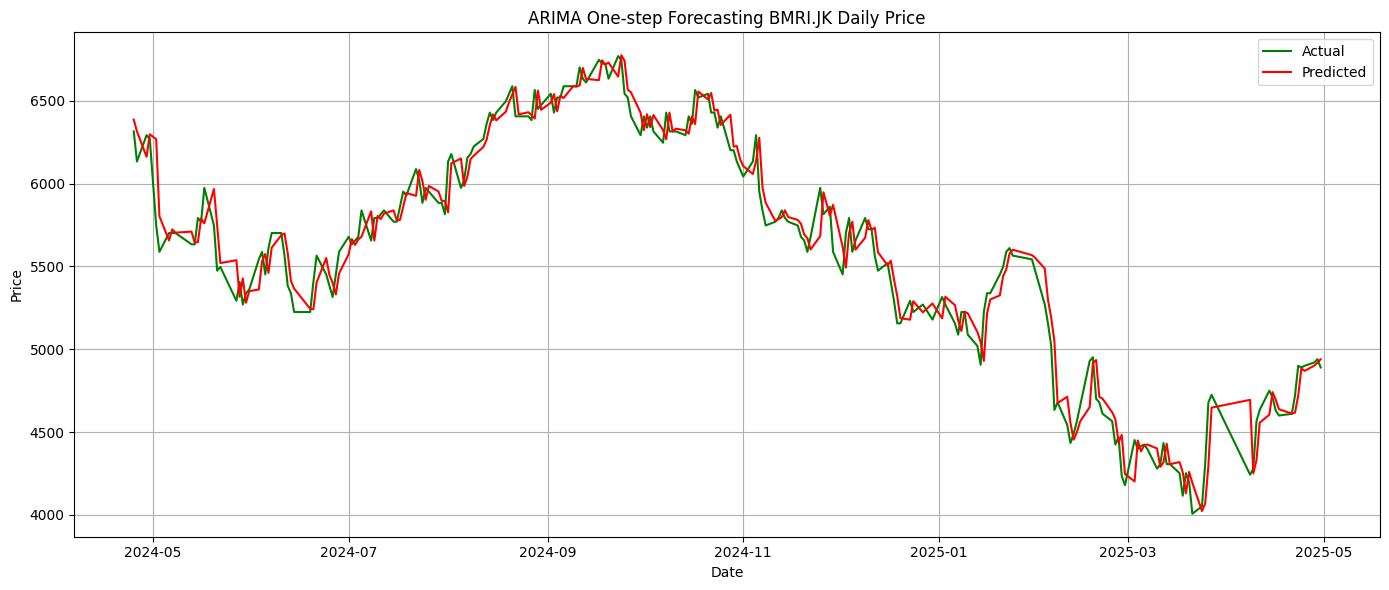

[*********************100%***********************]  1 of 1 completed



================================== TLKM.JK ==================================



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  720
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -3815.765
Date:                Fri, 28 Nov 2025   AIC                           7645.530
Time:                        19:26:02   BIC                           7677.575
Sample:                             0   HQIC                          7657.902
                                - 720                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5028      5.548      0.091      0.928     -10.372      11.377
ar.L1         -1.3863      0.016    -84.920      0.000      -1.418      -1.354
ar.L2         -0.9747      0.017    -58.762      0.0

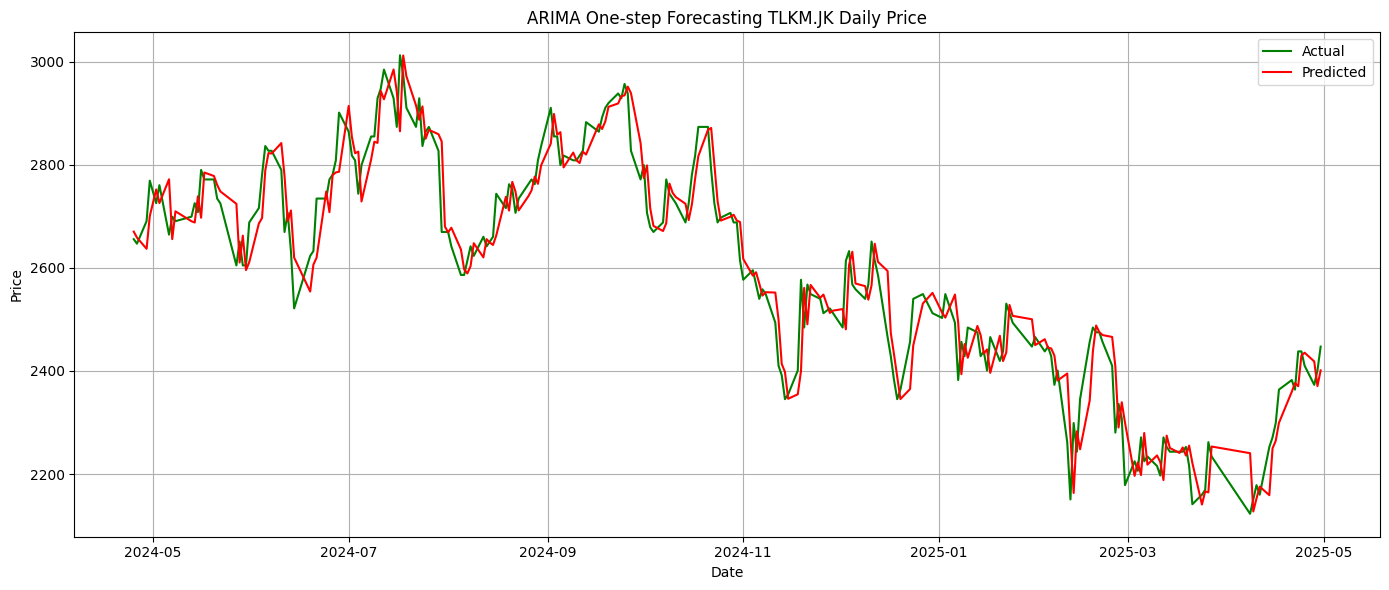

In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

stocks = ['ANTM.JK', 'BBNI.JK', 'BBRI.JK', 'BMRI.JK', 'TLKM.JK']

for stock in stocks:
    print(f"\n\n================================== {stock} ==================================\n")
    # ================================
    # 1. Download Data
    # ================================
    data = yf.download(stock, start='2021-05-01', end='2025-05-01')
    data = data[['Close']].dropna()
    data.rename(columns={'Close': 'Price'}, inplace=True)
    
    y_series = data[("Price", stock)].astype(float)
    y_series = y_series.sort_index()

    # ================================
    # 2. Train-Test Split (75% - 25%)
    # ================================
    train_size = int(len(y_series) * 0.75) 
    train, test = y_series[:train_size], y_series[train_size:]

    history = list(train)   
    predictions = []

    # ================================
    # 3. Fit Model 
    # ================================
    model = auto_arima(
        train,
        max_p=5,
        max_d=2,
        max_q=5,
        seasonal=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=False
    )
    
    print(model.summary())
    
    # Save model
    model_filename = f"best_arima_{stock}.pkl"
    joblib.dump(model, model_filename)
    print(f"Model saved as: {model_filename}")

    # ================================
    # 4. One-step Forecasting (Walk-forward)
    # ================================
    predictions = []

    for actual_value in test.values:
        yhat_pred = model.predict(n_periods=1)
        yhat = yhat_pred[0] if isinstance(yhat_pred, np.ndarray) else yhat_pred.iloc[0]  
        predictions.append(yhat)
        model.update(actual_value)

    # ================================
    # 5. Evaluasi
    # ================================
    pred_series = pd.Series(predictions, index=test.index)

    rmse = np.sqrt(mean_squared_error(test, pred_series))
    mape = mean_absolute_percentage_error(test, pred_series)

    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.6f}")

    # ================================
    # 6. Plot
    # ================================
    plt.figure(figsize=(14,6))
    plt.plot(test.index, test, label="Actual", color="green")
    plt.plot(pred_series.index, pred_series, label="Predicted", color="red")
    plt.title(f"ARIMA One-step Forecasting {stock} Daily Price")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Simulasi 30 hari

[*********************100%***********************]  1 of 1 completed



================================== ANTM.JK ==================================



RMSE: 42.1148
MAPE: 0.020330


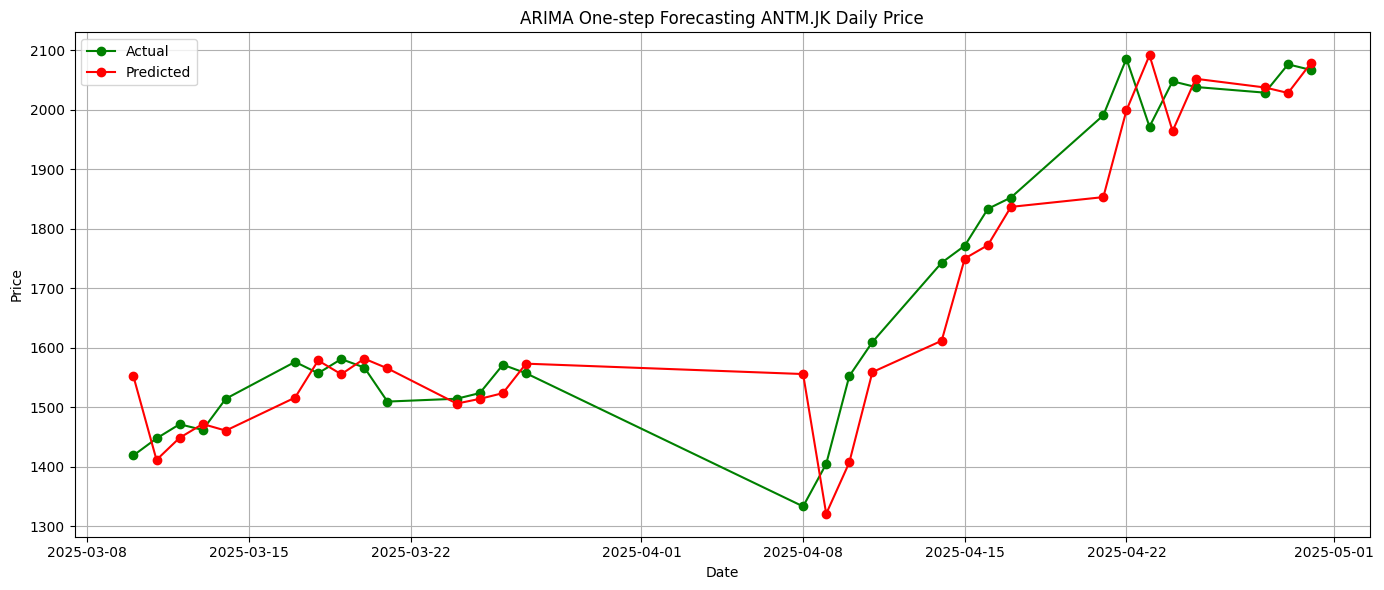

[*********************100%***********************]  1 of 1 completed

     1%   2%   3%   4%   5%
1%  0.0  0.0  0.0  0.0  0.0
2%  0.0  0.0  0.0  0.0  0.0
3%  0.0  0.0  0.0  0.0  0.0
4%  0.0  0.0  0.0  0.0  0.0
5%  0.0  0.0  0.0  0.0  0.0


================================== BBNI.JK ==================================



RMSE: 104.5659
MAPE: 0.018386


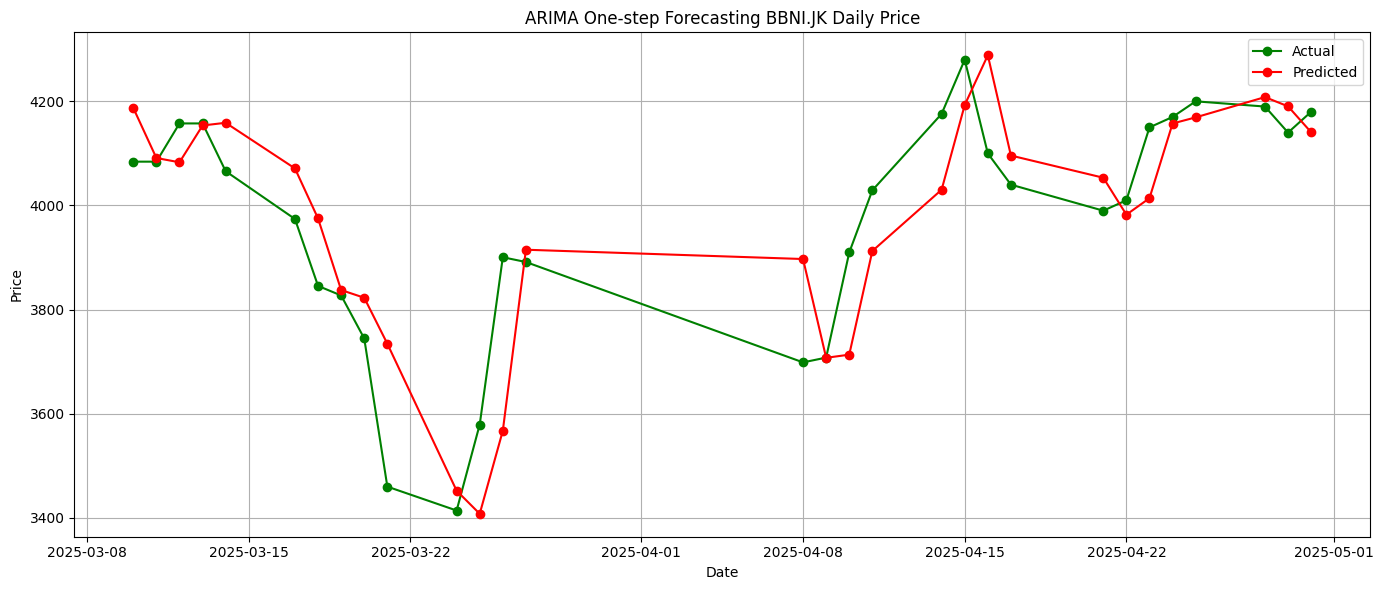

[*********************100%***********************]  1 of 1 completed

     1%   2%   3%   4%   5%
1%  0.0  0.0  0.0  0.0  0.0
2%  0.0  0.0  0.0  0.0  0.0
3%  0.0  0.0  0.0  0.0  0.0
4%  0.0  0.0  0.0  0.0  0.0
5%  0.0  0.0  0.0  0.0  0.0


================================== BBRI.JK ==================================



RMSE: 91.3166
MAPE: 0.017186


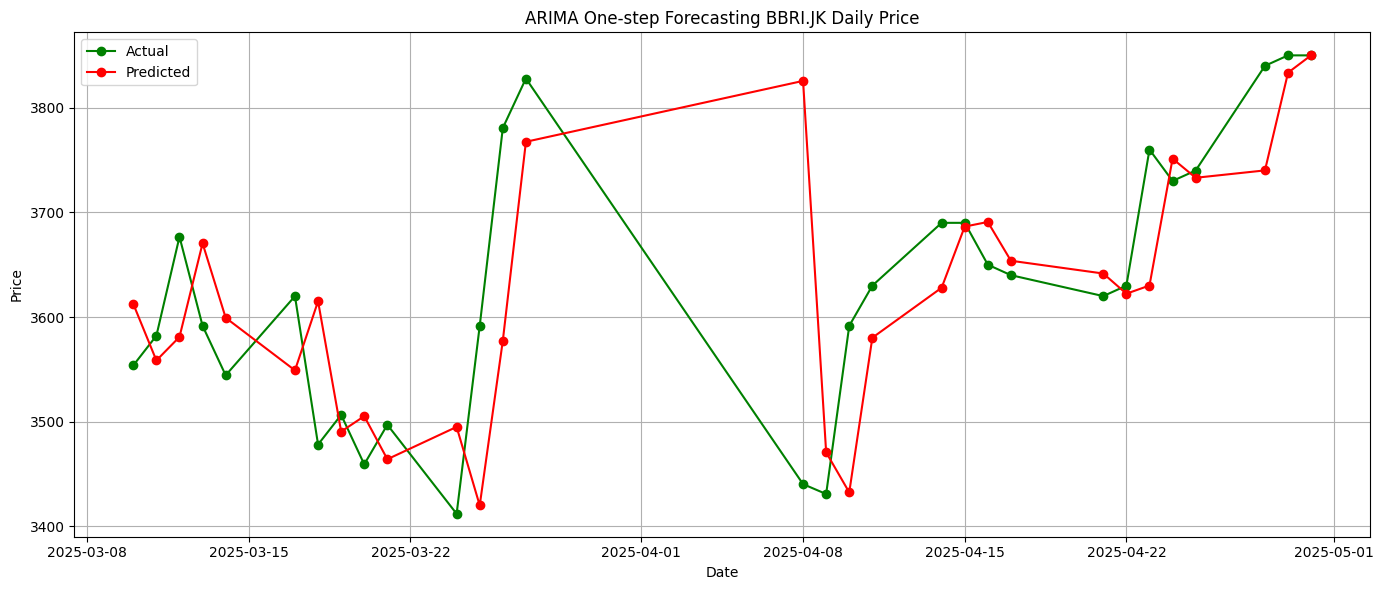

[*********************100%***********************]  1 of 1 completed

     1%   2%   3%   4%   5%
1%  0.0  0.0  0.0  0.0  0.0
2%  0.0  0.0  0.0  0.0  0.0
3%  0.0  0.0  0.0  0.0  0.0
4%  0.0  0.0  0.0  0.0  0.0
5%  0.0  0.0  0.0  0.0  0.0


================================== BMRI.JK ==================================



RMSE: 127.9106
MAPE: 0.017973


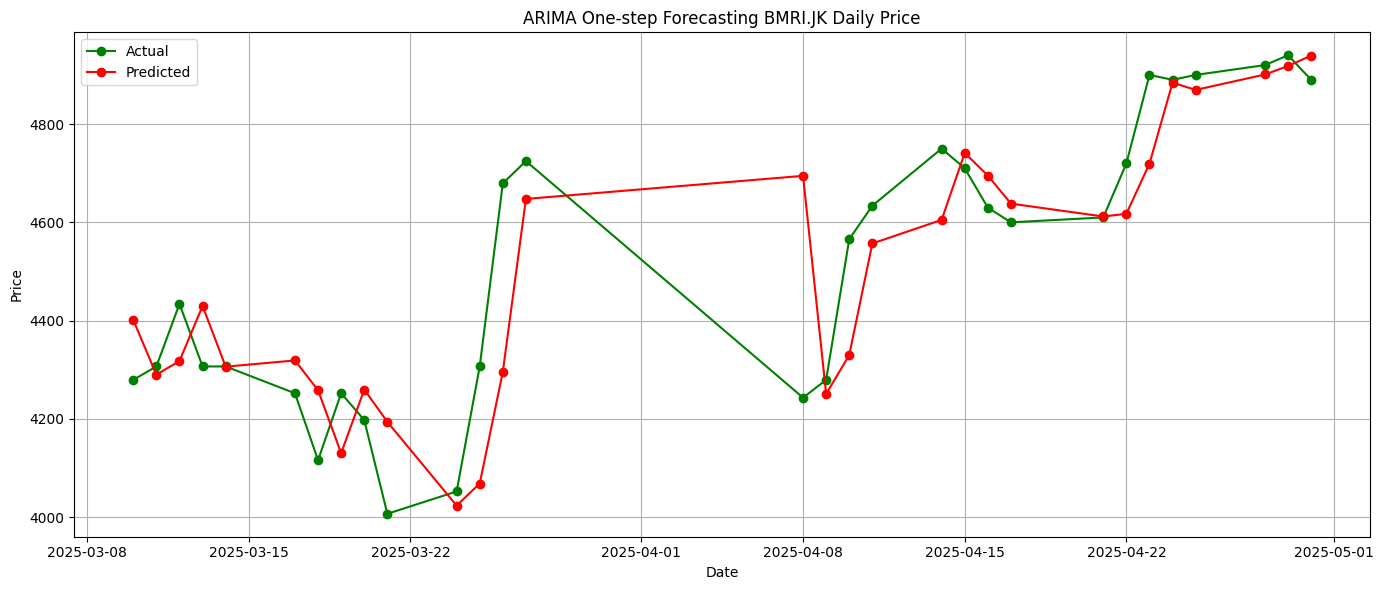

[*********************100%***********************]  1 of 1 completed

           1%   2%   3%   4%   5%
1%  14.266624  0.0  0.0  0.0  0.0
2%  14.266624  0.0  0.0  0.0  0.0
3%  14.266624  0.0  0.0  0.0  0.0
4%  14.266624  0.0  0.0  0.0  0.0
5%  14.266624  0.0  0.0  0.0  0.0


================================== TLKM.JK ==================================



RMSE: 55.5108
MAPE: 0.016655


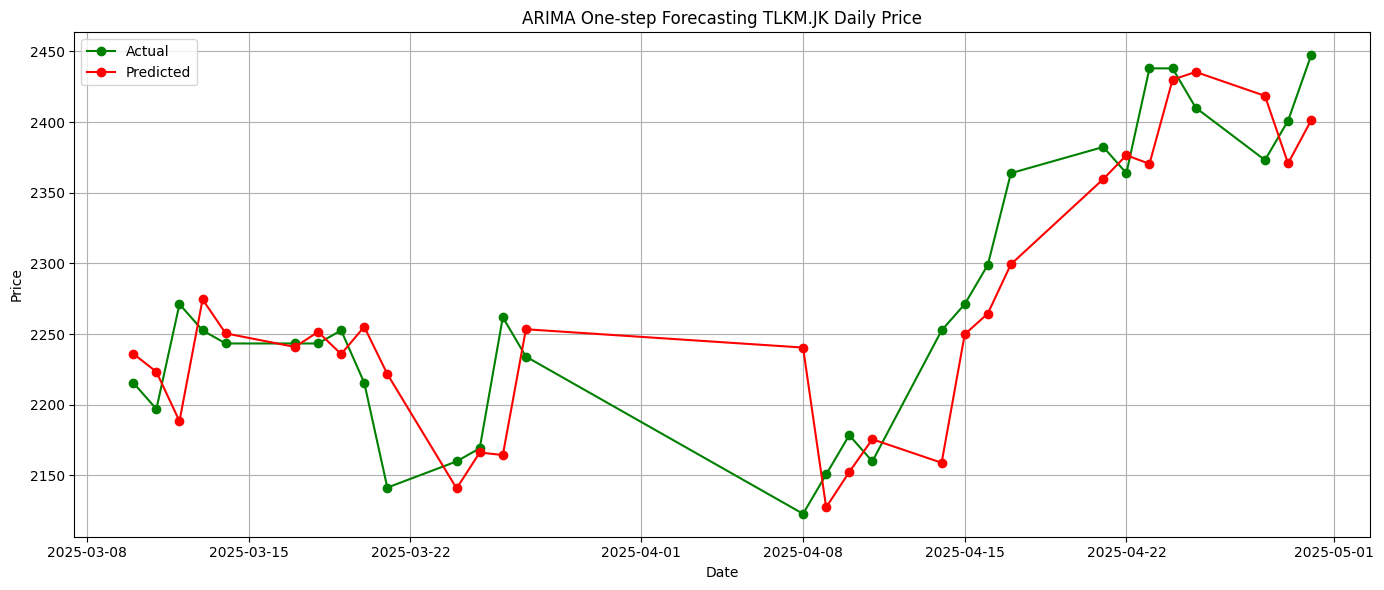

     1%   2%   3%   4%   5%
1%  0.0  0.0  0.0  0.0  0.0
2%  0.0  0.0  0.0  0.0  0.0
3%  0.0  0.0  0.0  0.0  0.0
4%  0.0  0.0  0.0  0.0  0.0
5%  0.0  0.0  0.0  0.0  0.0


In [7]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

def simulate_profit(actual_prices, predicted_prices, thresholds, step_ahead=1, initial_balance=1000000):
    results = pd.DataFrame(index=[f"{lt*100:.0f}%" for lt in thresholds],
                           columns=[f"{ut*100:.0f}%" for ut in thresholds])
    
    # 30 data test terakhir
    actual = actual_prices[-30:]
    predicted = predicted_prices[-30:]

    for lt in thresholds:
      for ut in thresholds:
        #   print("===================================================================")
        #   print(f"LT: {lt*100:.0f}%, UT: {ut*100:.0f}%")
          cash = initial_balance
          shares = 0

          for i in range(len(predicted) - step_ahead):
              curr_price = actual[i]
              next_pred_price = predicted[i + step_ahead]
              change = (next_pred_price - curr_price) / curr_price

              # Buy jika prediksi naik lebih dari upper threshold
              if change >= ut and shares == 0:
                  shares = cash / curr_price
                  cash = 0
                #   print(i, " : Buy - ", change, " : Change")

              # Sell jika prediksi turun lebih dari lower threshold
              elif change <= -lt and shares > 0:
                  cash = shares * curr_price
                  shares = 0
                #   print(i, " : Sell - ", change, " : Change")

            #   else:
            #       print(i, " : Hold - ", change, " : Change")

          # Akhir periode: jual kalau masih pegang
          if shares > 0:
              cash = shares * actual[-1]
              shares = 0

          total_return = (cash - initial_balance) / initial_balance * 100
          results.loc[f"{lt*100:.0f}%", f"{ut*100:.0f}%"] = total_return

    return results

stocks = ['ANTM.JK', 'BBNI.JK', 'BBRI.JK', 'BMRI.JK', 'TLKM.JK']

for stock in stocks:
    print(f"\n\n================================== {stock} ==================================\n")

    # ================================
    # 1. Load Data
    # ================================
    data = yf.download(stock, start='2021-05-01', end='2025-05-01')
    data = data[['Close']].dropna()
    data.rename(columns={'Close': 'Price'}, inplace=True)
    
    y_series = data[("Price", stock)].astype(float)
    y_series = y_series.sort_index()

    # ================================
    # 2. Train-Test Split (75% - 25%)
    # ================================
    train_size = int(len(y_series) * 0.75)
    train, test = y_series[:train_size], y_series[train_size:]

    # ================================
    # 3. Fit Model 
    # ================================
    model = joblib.load(f"best_arima_{stock}.pkl")

    # ================================
    # 4. One-step Forecasting (Walk-forward)
    # ================================
    predictions = []

    for actual_value in test.values:
        yhat_pred = model.predict(n_periods=1)
        yhat = yhat_pred[0] if isinstance(yhat_pred, np.ndarray) else yhat_pred.iloc[0]  
        predictions.append(yhat)
        model.update(actual_value)

    # ================================
    # 5. Evaluasi
    # ================================
    pred_series = pd.Series(predictions, index=test.index)

    rmse = np.sqrt(mean_squared_error(test, pred_series))
    mape = mean_absolute_percentage_error(test, pred_series)

    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.6f}")
    
    # ================================
    # 6. Plot
    # ================================
    plt.figure(figsize=(14,6))
    plt.plot(test.index[-30:], test[-30:], label="Actual", color="green", marker='o')
    plt.plot(pred_series.index[-30:], pred_series[-30:], label="Predicted", color="red", marker='o')
    plt.title(f"ARIMA One-step Forecasting {stock} Daily Price")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ================================
    # 7. Simulasi
    # ================================
    actual = test.values
    predicted = pred_series.values

    thresholds = [0.01, 0.02, 0.03, 0.04, 0.05]
    
    results = simulate_profit(actual, predicted, thresholds)
    print(results)

# Buy Hold Sell Simulasi

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

def get_signal(actual_prices, future_prices, step_ahead=1, lower_threshold=0.05, upper_threshold=0.05):
  signals = []
  for i in range(len(actual_prices) - step_ahead):
      curr_price = actual_prices[i]
      future_price = future_prices[i + step_ahead]
      change = (future_price - curr_price) / curr_price

      if change >= upper_threshold:
          signals.append("Buy")
      elif change <= -lower_threshold:
          signals.append("Sell")
      else:
          signals.append("Hold")
  return signals

stocks = ['ANTM.JK', 'BBNI.JK', 'BBRI.JK', 'BMRI.JK', 'TLKM.JK']

for i, stock in enumerate(stocks):
    print(f"\n\n================================== {stock} ==================================\n")

    # ================================
    # 1. Load Data
    # ================================
    data = yf.download(stock, start='2021-05-01', end='2025-05-01')
    data = data[['Close']].dropna()
    data.rename(columns={'Close': 'Price'}, inplace=True)
    
    y_series = data[("Price", stock)].astype(float)
    y_series = y_series.sort_index()

    # ================================
    # 2. Train-Test Split (75% - 25%)
    # ================================
    train_size = int(len(y_series) * 0.75)
    train, test = y_series[:train_size], y_series[train_size:]

    # ================================
    # 3. Load Model 
    # ================================
    model = joblib.load(f"best_arima_{stock}.pkl")

    # ================================
    # 4. One-step Forecasting (Walk-forward)
    # ================================
    predictions = []

    for actual_value in test.values:
        yhat_pred = model.predict(n_periods=1)
        yhat = yhat_pred[0] if isinstance(yhat_pred, np.ndarray) else yhat_pred.iloc[0]  
        predictions.append(yhat)
        model.update(actual_value)

    # ================================
    # 5. Evaluasi
    # ================================
    pred_series = pd.Series(predictions, index=test.index)

    rmse = np.sqrt(mean_squared_error(test, pred_series))
    mape = mean_absolute_percentage_error(test, pred_series)

    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.6f}")
    
    # ================================
    # 6. Rekomendasi Buy/Hold/Sell Aktual dan Prediksi
    # ================================
    step_ahead = 1
    thresholds = {
        "ANTM.JK": (0.01, 0.01),
        "BBNI.JK": (0.01, 0.01),
        "BBRI.JK": (0.01, 0.01),
        "BMRI.JK": (0.01, 0.01),
        "TLKM.JK": (0.01, 0.01)
    }
    
    lt, ut = thresholds[stock]

    test = test[-30:]
    pred_series = pred_series[-30:]
    
    signals_pred = get_signal(test, pred_series, step_ahead, lt, ut)
    
    # ================================
    # 7. Export ke Excel
    # ================================
    output_file = "hasil_rekomendasi_arima.xlsx"

    if i == 0:  # Jika sheet pertama → buat file baru
        mode = 'w'
    else:      # Sheet berikutnya → append
        mode = 'a'

    # Potong agar jumlah signal cocok
    actual_final = test[:-1]
    pred_final = pred_series[1:]


    df_out = pd.DataFrame({
        "Tanggal": "",
        "Harga Aktual": actual_final,
        "% Perubahan": "",
        "Signal Sistem": signals_pred,
        "Signal Ahli": "",
        "Alasan Ahli": ""
    })

    with pd.ExcelWriter(output_file, engine="openpyxl", mode=mode) as writer:
        df_out.to_excel(writer, sheet_name=stock.replace(".JK",""), index=False)

    print(f"➡ Data untuk {stock} berhasil disimpan ke sheet Excel!")



================================== ANTM.JK ==================================

RMSE: 43.9134
MAPE: 0.020012
➡ Data untuk ANTM.JK berhasil disimpan ke sheet Excel!


================================== BBNI.JK ==================================

RMSE: 104.0803
MAPE: 0.018154
➡ Data untuk BBNI.JK berhasil disimpan ke sheet Excel!


================================== BBRI.JK ==================================

RMSE: 93.9775
MAPE: 0.017371
➡ Data untuk BBRI.JK berhasil disimpan ke sheet Excel!


================================== BMRI.JK ==================================

RMSE: 128.0755
MAPE: 0.017724
➡ Data untuk BMRI.JK berhasil disimpan ke sheet Excel!


================================== TLKM.JK ==================================

RMSE: 61.0822
MAPE: 0.016499
➡ Data untuk TLKM.JK berhasil disimpan ke sheet Excel!


# Klasifikasi Buy Hold Sell

Ahli

In [10]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, accuracy_score, confusion_matrix, classification_report

def get_signal(actual_prices, future_prices, step_ahead=1, lower_threshold=0.05, upper_threshold=0.05):
  signals = []
  for i in range(len(actual_prices) - step_ahead):
      curr_price = actual_prices[i]
      future_price = future_prices[i + step_ahead]
      change = (future_price - curr_price) / curr_price

      if change >= upper_threshold:
          signals.append("Buy")
      elif change <= -lower_threshold:
          signals.append("Sell")
      else:
          signals.append("Hold")
  return signals

stocks = ['ANTM.JK', 'BBNI.JK', 'BBRI.JK', 'BMRI.JK', 'TLKM.JK']

expert_signals_dict = {
  "ANTM.JK": [
      "Hold","Hold","Hold","Hold","Hold","Hold","Hold","Hold","Hold","Buy",
      "Hold","Hold","Hold","Hold","Buy","Hold","Hold","Hold","Hold","Hold",
      "Hold","Hold","Hold","Hold","Hold","Hold","Hold","Hold","Hold"
  ],
  "BBNI.JK": [
        "Hold","Hold","Hold","Hold","Hold","Hold","Hold","Hold","Hold","Buy",
        "Hold","Hold","Hold","Hold","Buy","Hold","Hold","Hold","Hold","Sell",
        "Buy","Hold","Hold","Hold","Hold","Hold","Hold","Hold","Hold"
    ],
  "BBRI.JK": [
        "Hold","Hold","Hold","Hold","Hold","Hold","Buy","Hold","Hold","Hold",
        "Hold","Hold","Hold","Hold","Buy","Hold","Hold","Hold","Hold","Hold",
        "Hold","Hold","Hold","Hold","Hold","Hold","Hold","Hold", "Hold"
    ],
  "BMRI.JK": [
        "Buy","Hold","Hold","Hold","Hold","Hold","Hold","Hold","Hold","Buy",
        "Hold","Hold","Sell","Hold","Buy","Buy","Hold","Hold","Hold","Hold",
        "Hold","Hold","Hold","Hold","Sell","Hold","Hold","Hold","Hold"
    ],
  "TLKM.JK": [
        "Hold","Hold","Hold","Hold","Hold","Hold","Hold","Hold","Hold","Sell",
        "Hold","Hold","Hold","Hold","Buy","Hold","Hold","Hold","Sell","Hold",
        "Hold","Hold","Hold","Hold","Hold","Hold","Hold","Hold","Hold"
    ]
}

for stock in stocks:
    print(f"\n\n================================== {stock} ==================================\n")

    # ================================
    # 1. Load Data
    # ================================
    data = yf.download(stock, start='2021-05-01', end='2025-05-01')
    data = data[['Close']].dropna()
    data.rename(columns={'Close': 'Price'}, inplace=True)
    
    y_series = data[("Price", stock)].astype(float)
    y_series = y_series.sort_index()

    # ================================
    # 2. Train-Test Split (75% - 25%)
    # ================================
    train_size = int(len(y_series) * 0.75)
    train, test = y_series[:train_size], y_series[train_size:]

    # ================================
    # 3. Load Model 
    # ================================
    model = joblib.load(f"best_arima_{stock}.pkl")

    # ================================
    # 4. One-step Forecasting (Walk-forward)
    # ================================
    predictions = []

    for actual_value in test.values:
        yhat_pred = model.predict(n_periods=1)
        yhat = yhat_pred[0] if isinstance(yhat_pred, np.ndarray) else yhat_pred.iloc[0]  
        predictions.append(yhat)
        model.update(actual_value)

    # ================================
    # 5. Evaluasi
    # ================================
    pred_series = pd.Series(predictions, index=test.index)

    rmse = np.sqrt(mean_squared_error(test, pred_series))
    mape = mean_absolute_percentage_error(test, pred_series)

    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.6f}")
    
    # ================================
    # 6. Rekomendasi Buy/Hold/Sell Aktual dan Prediksi
    # ================================
    step_ahead = 1
    thresholds = {
        "ANTM.JK": (0.01, 0.01),
        "BBNI.JK": (0.01, 0.01),
        "BBRI.JK": (0.01, 0.01),
        "BMRI.JK": (0.01, 0.01),
        "TLKM.JK": (0.01, 0.01)
    }
    
    lt, ut = thresholds[stock]
    
    test = test[-30:]
    pred_series = pred_series[-30:]
    
    signals_pred = get_signal(test, pred_series, step_ahead, lt, ut)

    # ================================
    # 8. Evaluasi akurasi sinyal
    # ================================
    expert_signals = expert_signals_dict[stock]

    cm = confusion_matrix(expert_signals, signals_pred, labels=["Buy","Hold","Sell"])
    print("Confusion Matrix:")
    print(cm)

    print("\nClassification Report:")
    print(classification_report(expert_signals, signals_pred, labels=["Buy","Hold","Sell"]))

    acc = accuracy_score(expert_signals, signals_pred)
    print(f"Accuracy: {acc:.4f}")

[*********************100%***********************]  1 of 1 completed



================================== ANTM.JK ==================================




[*********************100%***********************]  1 of 1 completed

RMSE: 42.1148
MAPE: 0.020330
Confusion Matrix:
[[ 0  2  0]
 [ 0 27  0]
 [ 0  0  0]]

Classification Report:
              precision    recall  f1-score   support

         Buy       0.00      0.00      0.00         2
        Hold       0.93      1.00      0.96        27
        Sell       0.00      0.00      0.00         0

    accuracy                           0.93        29
   macro avg       0.31      0.33      0.32        29
weighted avg       0.87      0.93      0.90        29

Accuracy: 0.9310


================================== BBNI.JK ==================================




[*********************100%***********************]  1 of 1 completed

RMSE: 104.5659
MAPE: 0.018386
Confusion Matrix:
[[ 0  3  0]
 [ 0 25  0]
 [ 0  1  0]]

Classification Report:
              precision    recall  f1-score   support

         Buy       0.00      0.00      0.00         3
        Hold       0.86      1.00      0.93        25
        Sell       0.00      0.00      0.00         1

    accuracy                           0.86        29
   macro avg       0.29      0.33      0.31        29
weighted avg       0.74      0.86      0.80        29

Accuracy: 0.8621


================================== BBRI.JK ==================================




[*********************100%***********************]  1 of 1 completed

RMSE: 91.3166
MAPE: 0.017186
Confusion Matrix:
[[ 0  2  0]
 [ 0 27  0]
 [ 0  0  0]]

Classification Report:
              precision    recall  f1-score   support

         Buy       0.00      0.00      0.00         2
        Hold       0.93      1.00      0.96        27
        Sell       0.00      0.00      0.00         0

    accuracy                           0.93        29
   macro avg       0.31      0.33      0.32        29
weighted avg       0.87      0.93      0.90        29

Accuracy: 0.9310


================================== BMRI.JK ==================================




[*********************100%***********************]  1 of 1 completed

RMSE: 127.9106
MAPE: 0.017973
Confusion Matrix:
[[ 1  3  0]
 [ 0 23  0]
 [ 0  2  0]]

Classification Report:
              precision    recall  f1-score   support

         Buy       1.00      0.25      0.40         4
        Hold       0.82      1.00      0.90        23
        Sell       0.00      0.00      0.00         2

    accuracy                           0.83        29
   macro avg       0.61      0.42      0.43        29
weighted avg       0.79      0.83      0.77        29

Accuracy: 0.8276


================================== TLKM.JK ==================================



RMSE: 55.5108
MAPE: 0.016655
Confusion Matrix:
[[ 0  1  0]
 [ 0 26  0]
 [ 0  2  0]]

Classification Report:
              precision    recall  f1-score   support

         Buy       0.00      0.00      0.00         1
        Hold       0.90      1.00      0.95        26
        Sell       0.00      0.00      0.00         2

    accuracy                           0.90        29
   macro avg       0.30      0.33      0.32        29
weighted avg       0.80      0.90      0.85        29

Accuracy: 0.8966


Actual

[*********************100%***********************]  1 of 1 completed



================================== ANTM.JK ==================================



RMSE: 42.1148
MAPE: 0.020330

Akurasi sinyal Buy/Hold/Sell: 0.3416666666666667

Classification Report:
              precision    recall  f1-score   support

         Buy       0.00      0.00      0.00        88
        Hold       0.34      1.00      0.51        82
        Sell       0.00      0.00      0.00        70

    accuracy                           0.34       240
   macro avg       0.11      0.33      0.17       240
weighted avg       0.12      0.34      0.17       240


Confusion Matrix:
[[ 0 88  0]
 [ 0 82  0]
 [ 0 70  0]]


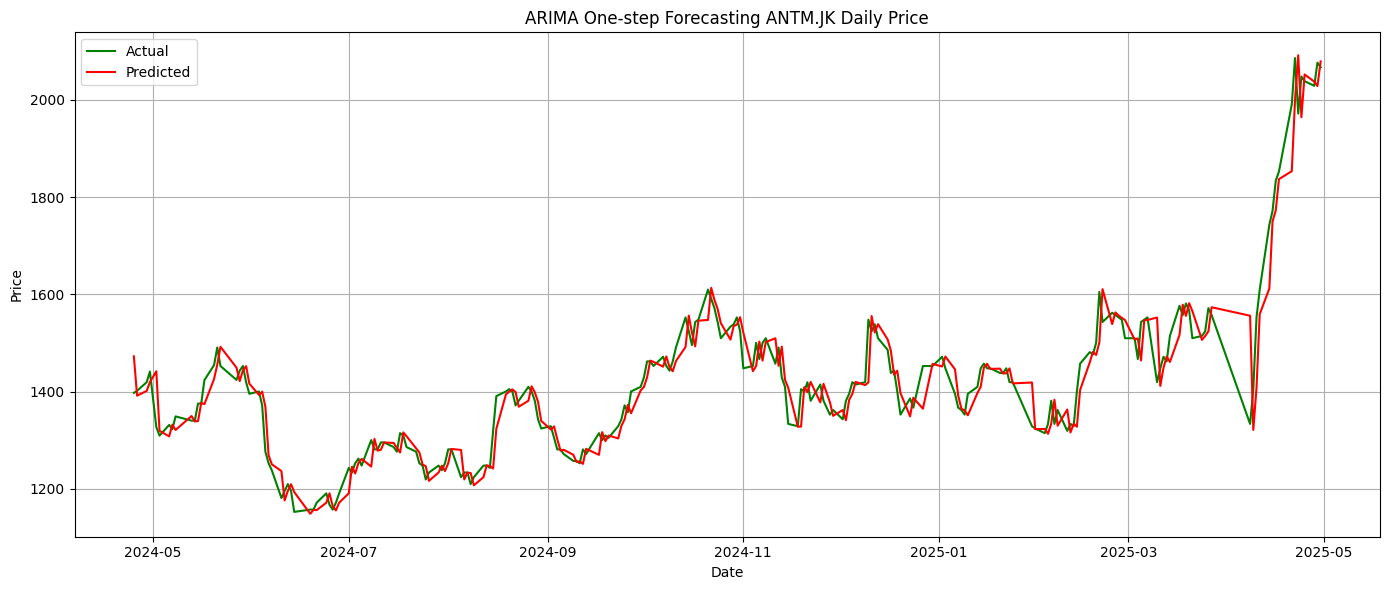

[*********************100%***********************]  1 of 1 completed



================================== BBNI.JK ==================================



RMSE: 104.5659
MAPE: 0.018386

Akurasi sinyal Buy/Hold/Sell: 0.42916666666666664

Classification Report:
              precision    recall  f1-score   support

         Buy       0.00      0.00      0.00        65
        Hold       0.43      1.00      0.60       103
        Sell       0.00      0.00      0.00        72

    accuracy                           0.43       240
   macro avg       0.14      0.33      0.20       240
weighted avg       0.18      0.43      0.26       240


Confusion Matrix:
[[  0  65   0]
 [  0 103   0]
 [  0  72   0]]


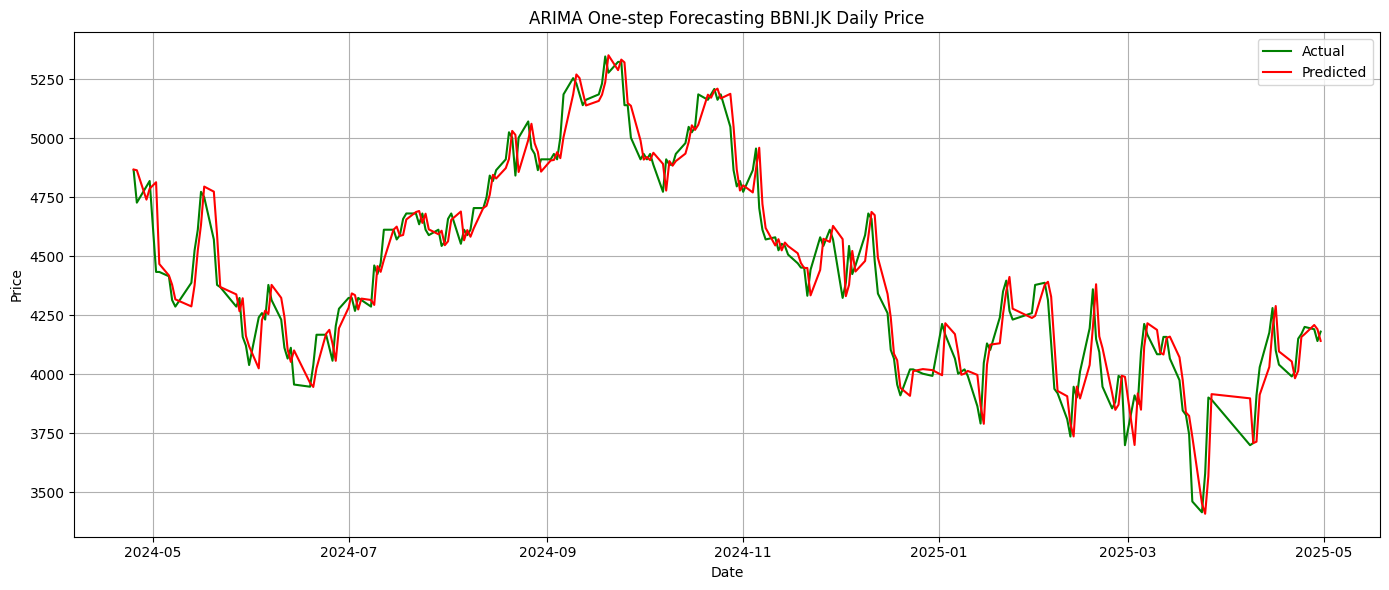

[*********************100%***********************]  1 of 1 completed



================================== BBRI.JK ==================================



RMSE: 91.3166
MAPE: 0.017186

Akurasi sinyal Buy/Hold/Sell: 0.4125

Classification Report:
              precision    recall  f1-score   support

         Buy       0.00      0.00      0.00        63
        Hold       0.41      1.00      0.58        99
        Sell       0.00      0.00      0.00        78

    accuracy                           0.41       240
   macro avg       0.14      0.33      0.19       240
weighted avg       0.17      0.41      0.24       240


Confusion Matrix:
[[ 0 63  0]
 [ 0 99  0]
 [ 0 78  0]]


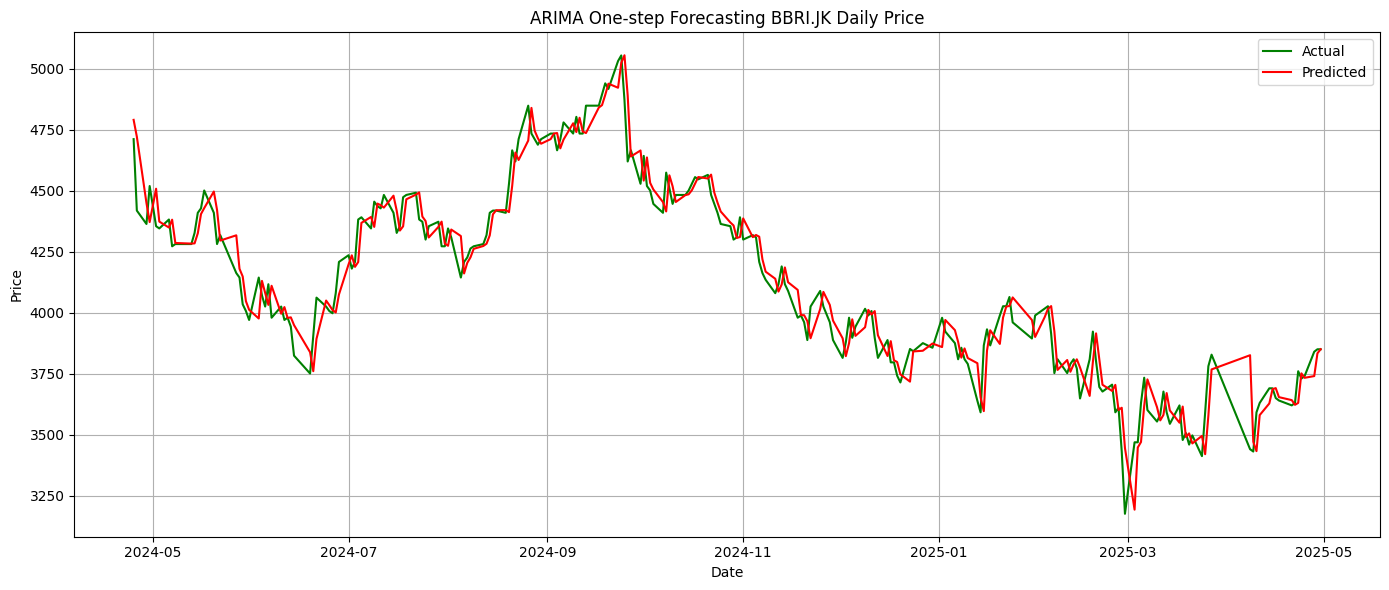

[*********************100%***********************]  1 of 1 completed



================================== BMRI.JK ==================================



RMSE: 127.9106
MAPE: 0.017973

Akurasi sinyal Buy/Hold/Sell: 0.37916666666666665

Classification Report:
              precision    recall  f1-score   support

         Buy       1.00      0.03      0.06        69
        Hold       0.37      1.00      0.54        89
        Sell       0.00      0.00      0.00        82

    accuracy                           0.38       240
   macro avg       0.46      0.34      0.20       240
weighted avg       0.43      0.38      0.22       240


Confusion Matrix:
[[ 2 67  0]
 [ 0 89  0]
 [ 0 82  0]]


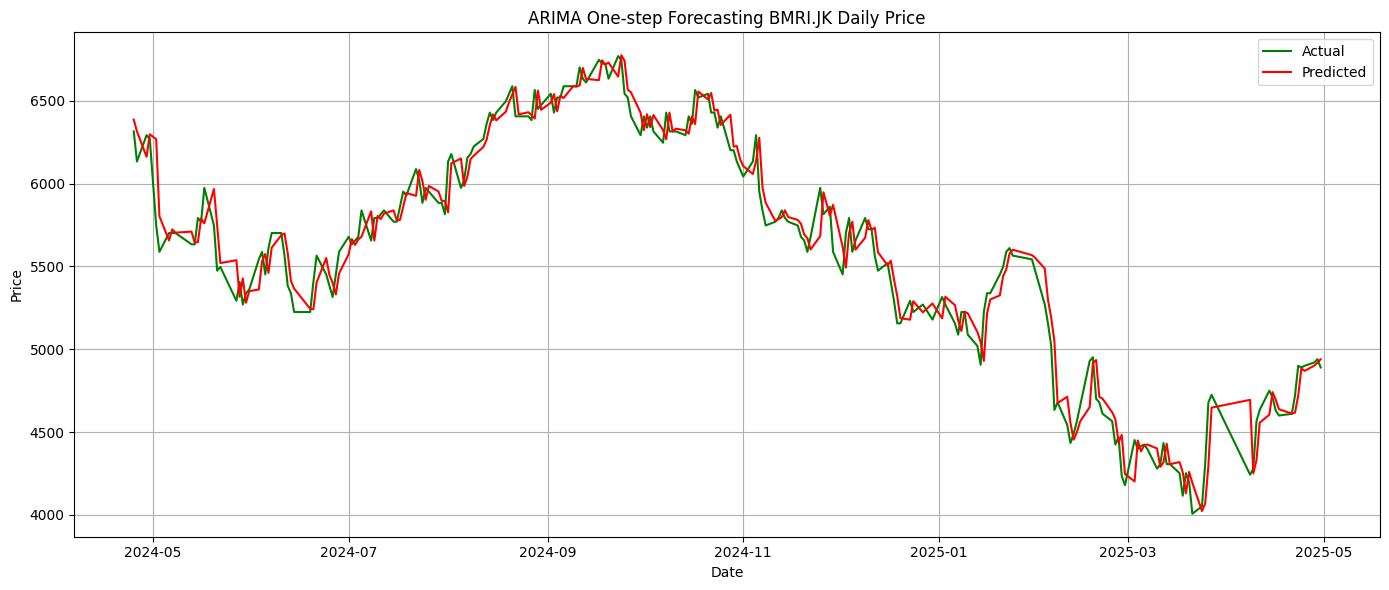

[*********************100%***********************]  1 of 1 completed



================================== TLKM.JK ==================================



RMSE: 55.5108
MAPE: 0.016655

Akurasi sinyal Buy/Hold/Sell: 0.4041666666666667

Classification Report:
              precision    recall  f1-score   support

         Buy       1.00      0.01      0.03        68
        Hold       0.40      1.00      0.57        96
        Sell       0.00      0.00      0.00        76

    accuracy                           0.40       240
   macro avg       0.47      0.34      0.20       240
weighted avg       0.44      0.40      0.24       240


Confusion Matrix:
[[ 1 67  0]
 [ 0 96  0]
 [ 0 76  0]]


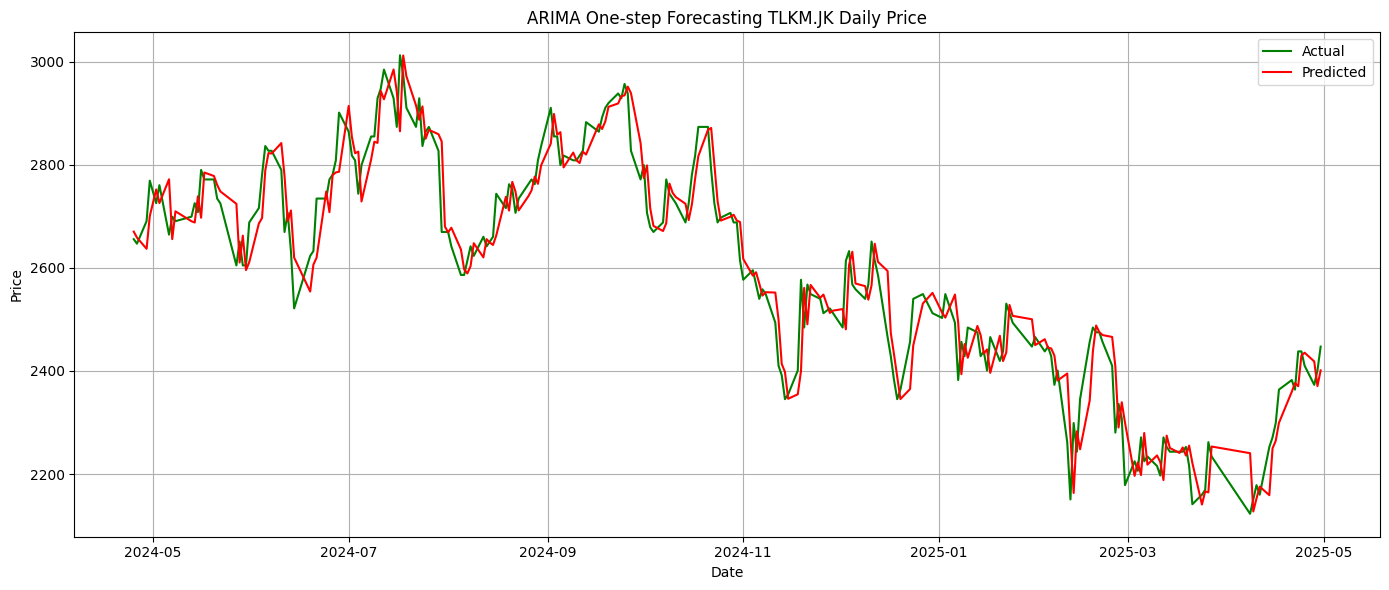

In [11]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, accuracy_score, confusion_matrix, classification_report

def get_signal(actual_prices, future_prices, step_ahead=1, lower_threshold=0.05, upper_threshold=0.05):
  signals = []
  for i in range(len(actual_prices) - step_ahead):
      curr_price = actual_prices[i]
      future_price = future_prices[i + step_ahead]
      change = (future_price - curr_price) / curr_price

      if change >= upper_threshold:
          signals.append("Buy")
      elif change <= -lower_threshold:
          signals.append("Sell")
      else:
          signals.append("Hold")
  return signals

stocks = ['ANTM.JK', 'BBNI.JK', 'BBRI.JK', 'BMRI.JK', 'TLKM.JK']

for stock in stocks:
    print(f"\n\n================================== {stock} ==================================\n")

    # ================================
    # 1. Load Data
    # ================================
    data = yf.download(stock, start='2021-05-01', end='2025-05-01')
    data = data[['Close']].dropna()
    data.rename(columns={'Close': 'Price'}, inplace=True)
    
    y_series = data[("Price", stock)].astype(float)
    y_series = y_series.sort_index()

    # ================================
    # 2. Train-Test Split (75% - 25%)
    # ================================
    train_size = int(len(y_series) * 0.75)
    train, test = y_series[:train_size], y_series[train_size:]

    # ================================
    # 3. Load Model 
    # ================================
    model = joblib.load(f"best_arima_{stock}.pkl")

    # ================================
    # 4. One-step Forecasting (Walk-forward)
    # ================================
    predictions = []

    for actual_value in test.values:
        yhat_pred = model.predict(n_periods=1)
        yhat = yhat_pred[0] if isinstance(yhat_pred, np.ndarray) else yhat_pred.iloc[0]  
        predictions.append(yhat)
        model.update(actual_value)

    # ================================
    # 5. Evaluasi
    # ================================
    pred_series = pd.Series(predictions, index=test.index)

    rmse = np.sqrt(mean_squared_error(test, pred_series))
    mape = mean_absolute_percentage_error(test, pred_series)

    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.6f}")
    
    # ================================
    # 6. Rekomendasi Buy/Hold/Sell Aktual dan Prediksi
    # ================================
    step_ahead = 1
    thresholds = {
        "ANTM.JK": (0.01, 0.01),
        "BBNI.JK": (0.01, 0.01),
        "BBRI.JK": (0.01, 0.01),
        "BMRI.JK": (0.01, 0.01),
        "TLKM.JK": (0.01, 0.01)
    }
    
    lt, ut = thresholds[stock]
    signals_actual = get_signal(test, test, step_ahead, lt, ut)
    signals_pred = get_signal(test, pred_series, step_ahead, lt, ut)

    # ================================
    # 8. Evaluasi akurasi sinyal
    # ================================
    accuracy = accuracy_score(signals_actual, signals_pred)
    print("\nAkurasi sinyal Buy/Hold/Sell:", accuracy)

    print("\nClassification Report:")
    print(classification_report(signals_actual, signals_pred))

    print("\nConfusion Matrix:")
    print(confusion_matrix(signals_actual, signals_pred))

    # ================================
    # 9. Plot
    # ================================
    plt.figure(figsize=(14,6))
    plt.plot(test.index, test, label="Actual", color="green")
    plt.plot(pred_series.index, pred_series, label="Predicted", color="red")
    plt.title(f"ARIMA One-step Forecasting {stock} Daily Price")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
